# Data Analysis "Kickstarter.csv"

In [283]:
!pip install pyspark

## Data Description

o ID : Unique Kickstarter ID                                          
o name : Name of proposal                                                        
o category : Specific category of project                                        
o main_category : Parent Categories                                              
o currency : Original currency                                                  
o deadline : Project expiry date                                                 
o goal : Goal of product in respective currency                                  
o launched : Project launch date                                                 
o pledged : Amount of pledged before deadline                                   
o state : State of project -- fail, success, ...                                 
o backers : Number of backers for a project                                     
o country : Country of project                                                   
o usd pledged : Pledged amount converted to USD (by Kickstarter)                 
o usd_pledged_real : Pledged amount converted to USD (by Fixer.io)               
o usd_goal_real : Goal amount converted to USD (by Fixer.io)

## Imports

In [284]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, sum, when, col
from pyspark.ml.feature import Imputer

## Setting up the Spark session

In [285]:
spark = SparkSession.builder \
    .appName("kick_starter-SparkDataFrame") \
    .getOrCreate()

data = spark.read.csv("kick_starter.csv", header=True, inferSchema=True)

### Data Shape

In [286]:
# Get the number of rows and columns
num_rows = data.count()
num_columns = len(data.columns)

# Shape of the DataFrame
data_shape = (num_rows, num_columns)

print("Shape of the DataFrame:", data_shape)

Shape of the DataFrame: (177432, 15)


In [287]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- pledged: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd pledged: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



In [288]:
data.head(5)

[Row(ID=1000002330, name='The Songs of Adelaide & Abullah', category='Poetry', main_category='Publishing', currency='GBP', deadline='2015-10-09', goal='1000.00', launched='2015-08-11 12:12:28', pledged='0.00', state='failed', backers='0', country='GB', usd pledged='0.00', usd_pledged_real='0.00', usd_goal_real='1533.95'),
 Row(ID=1000003930, name='Greeting From Earth: ZGAC Arts Capsule For ET', category='Narrative Film', main_category='Film & Video', currency='USD', deadline='2017-11-01', goal='30000.00', launched='2017-09-02 04:43:57', pledged='2421.00', state='failed', backers='15', country='US', usd pledged='100.00', usd_pledged_real='2421.00', usd_goal_real='30000.00'),
 Row(ID=1000004038, name='Where is Hank?', category='Narrative Film', main_category='Film & Video', currency='USD', deadline='2013-02-26', goal='45000.00', launched='2013-01-12 00:20:50', pledged='220.00', state='failed', backers='3', country='US', usd pledged='220.00', usd_pledged_real='220.00', usd_goal_real='4500

## Data Processing

### Dropping Necessary columns




In [289]:
data = data.drop('pledged', 'usd pledged') # pledged coulmn are being dropped because it the target on what we what to acheive by the machine learning model
data.printSchema()                         # usd pledged coulmn are being droped because coulmn usd pledged real has same values i choose the other this coulmn not the  other because it contains les missing values

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: string (nullable = true)
 |-- goal: string (nullable = true)
 |-- launched: string (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: string (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged_real: string (nullable = true)
 |-- usd_goal_real: string (nullable = true)



### Missing Values

In [290]:
# Calculate missing values
missing_values = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().head()
print("Missing Values:")
missing_values

Missing Values:


,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,0,1,1,4,5,6,6,6,6,6,6,10,6


In [291]:
# Handle missing values
data = data.dropna(subset=['name', 'currency'])  # Drop rows with missing values in 'name' and 'currency' columns

# Impute missing values in 'usd_goal_real' column with mean
usd_pledged_mean = data.select(avg('usd_goal_real')).collect()[0][0]
data = data.fillna({'usd_goal_real': usd_pledged_mean})

### Duplicates

In [292]:
# Before removing duplicates
rows_before = data.count()

# Handle duplicates
data = data.dropDuplicates()

# after removing duplicates
rows_after = data.count()

print("Number of rows before removing duplicates:", rows_before)
print("Number of rows after removing duplicates:", rows_after)

Number of rows before removing duplicates: 177426
Number of rows after removing duplicates: 177426


### Incorrect Format

In [293]:
from pyspark.sql.functions import to_timestamp
incorrect_format = data.filter(
    (data["goal"].cast("double").isNull()) |
    (data["backers"].cast("int").isNull()) |
    (data["usd_goal_real"].cast("double").isNull()) |
    (data["country"].cast("string").isNull()) |
    (data["usd_goal_real"].cast("double").isNull())

)
incorrect_format.show(truncate=False)

+----------+-----------------------------------------------------+------------------------------------------------+-----------------------+----------------+----------+----------+----------+-------------------+----------+----------+----------------+-------------+
|ID        |name                                                 |category                                        |main_category          |currency        |deadline  |goal      |launched  |state              |backers   |country   |usd_pledged_real|usd_goal_real|
+----------+-----------------------------------------------------+------------------------------------------------+-----------------------+----------------+----------+----------+----------+-------------------+----------+----------+----------------+-------------+
|1468633101|"""A Perfect Ending""                                | the new feature film from Nicole Conn."        |Shorts                 |Film & Video    |USD       |2010-11-29|50000.00  |53585.00           |su

In [294]:
# Count the rows with incorrect format
incorrect_format_count = incorrect_format.count()
print("Count of rows with incorrect format:", incorrect_format_count)

Count of rows with incorrect format: 637


In [295]:
data = data.exceptAll(incorrect_format)

### Transformation

In [296]:
from pyspark.sql.functions import to_timestamp

# Transformation and type casting
data = data.withColumn("goal", data["goal"].cast("double")) \
           .withColumn("backers", data["backers"].cast("int")) \
           .withColumn("usd_goal_real", data["usd_goal_real"].cast("double")) \
           .withColumn("country", data["country"].cast("string")) \
           .withColumn("launched", to_timestamp(data["launched"], "MM/dd/yyyy h:mm:ss a")) \
           .withColumn("usd_pledged_real", data["usd_pledged_real"].cast("double")) \
           .withColumn("deadline", to_timestamp(data["deadline"], "MM/dd/yyyy"))

In [297]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- deadline: timestamp (nullable = true)
 |-- goal: double (nullable = true)
 |-- launched: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- backers: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- usd_pledged_real: double (nullable = true)
 |-- usd_goal_real: double (nullable = true)



# Data Analysis " Queries " + Visualization

In [298]:
from pyspark.sql.functions import avg, count, sum, when, to_timestamp, datediff, year
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Query 1

### In this query the distrbution of the states of the project on the csv

In [299]:
# Group by the "state" column and count the occurrences
state_distribution = data.groupBy("state").count()

# Show the results
state_distribution.show()


+----------+-----+
|     state|count|
+----------+-----+
| suspended|  851|
|    failed|92081|
|  canceled|18170|
|successful|62732|
|      live| 1310|
| undefined| 1645|
+----------+-----+



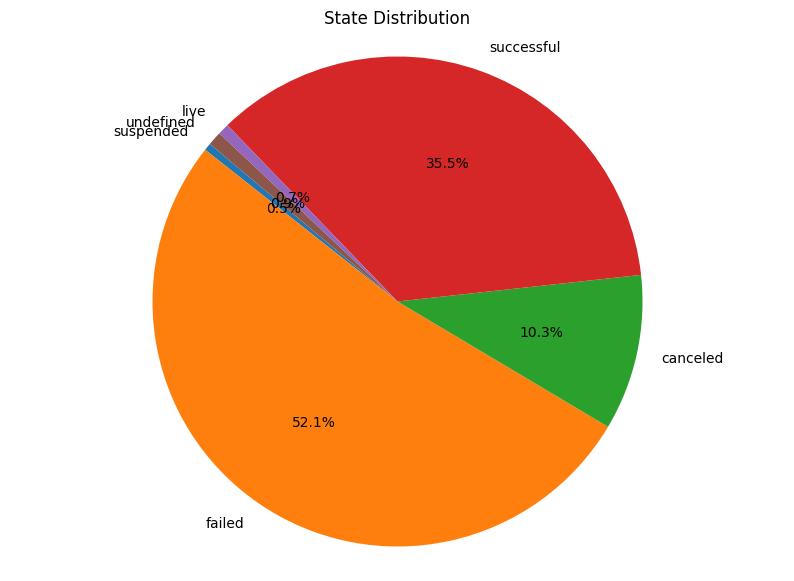

In [300]:
# Convert to Pandas DataFrame for visualization
state_distribution_pd = state_distribution.toPandas()

# Plotting with Matplotlib
plt.figure(figsize=(10, 7))
plt.pie(state_distribution_pd['count'], labels=state_distribution_pd['state'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("State Distribution")
plt.show()

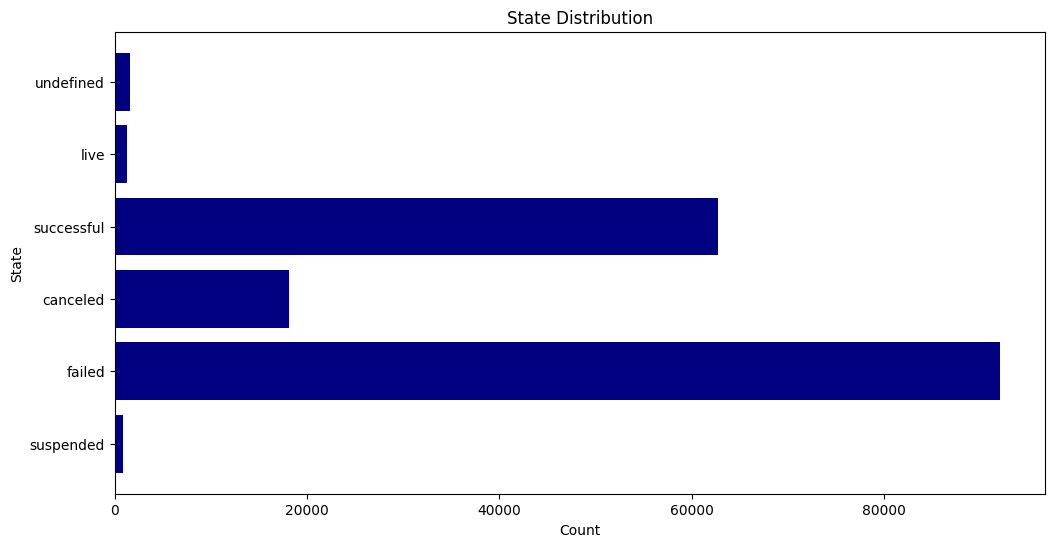

In [301]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))
plt.barh(state_distribution_pd['state'], state_distribution_pd['count'], color='navy')
plt.ylabel('State')
plt.xlabel('Count')
plt.title('State Distribution')
plt.show()

## Query Insights

Very interesting distribution !
we can see that only 35,38% of all projects got sucess.
More than 60% have failed or canceled.

## Query 2

### In this query We are checking the percentage of successfull and failed projects in each category

In [302]:
# Calculate the total count of projects by category
category_counts = data.groupBy("category").agg(count("*").alias("total_count"))

# Calculate the count of successful projects by category
success_counts = data.filter(data.state == "successful") \
    .groupBy("category").agg(count("*").alias("success_count"))

# Calculate the count of failed projects by category
failure_counts = data.filter(data.state == "failed") \
    .groupBy("category").agg(count("*").alias("failure_count"))

# Join the counts to calculate success and failure rates
rates = category_counts.join(success_counts, "category", "left") \
    .join(failure_counts, "category", "left") \
    .fillna(0)

# Calculate success and failure rates
rates = rates.withColumn("success_rate", rates["success_count"] / rates["total_count"]) \
    .withColumn("failure_rate", rates["failure_count"] / rates["total_count"])

# Get the top 15 categories by total count of projects
top_categories = rates.orderBy("total_count", ascending=False).limit(15)


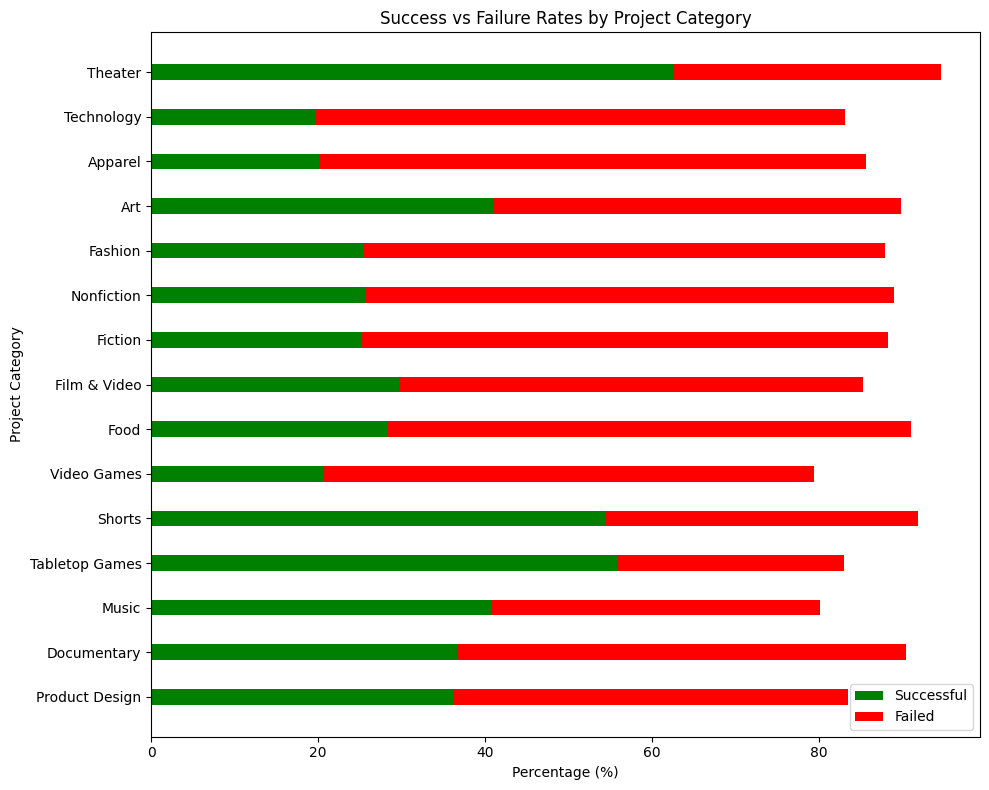

In [303]:
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame for visualization
top_categories_pd = top_categories.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 8))

index = np.arange(len(top_categories_pd))  # Using numpy array for indexing
bar_height = 0.35

plt.barh(index, top_categories_pd["success_rate"] * 100, bar_height, label='Successful', color='green')
plt.barh(index, top_categories_pd["failure_rate"] * 100, bar_height, label='Failed', color='red', left=top_categories_pd["success_rate"] * 100)

plt.ylabel('Project Category')
plt.xlabel('Percentage (%)')
plt.title('Success vs Failure Rates by Project Category')
plt.yticks(index, top_categories_pd["category"])
plt.legend()

plt.tight_layout()
plt.show()


## Query Insights

Tabletop games ,Theater, and Shorts have the highest success rates and Technology, Appearel, and video games have the lowest.

## Query 3

### What Categories of projects are being funded?

In [304]:
# Group by project ID, name, category, currency, and usd_pledged_real
grouped_data = data.groupBy("name", "category") \
    .agg({"usd_pledged_real": "sum"}) \
    .withColumnRenamed("sum(usd_pledged_real)", "total_usd_pledged_real")

# Sort the projects by total USD pledged amount in descending order
sorted_data = grouped_data.orderBy(col("total_usd_pledged_real").desc())

# Select the top 15 highest funded projects
top_15_projects = sorted_data.limit(15)

# Show the top 15 highest funded projects
top_15_projects.select("name", "category","total_usd_pledged_real").show(truncate=False)

+------------------------------------------------------------+---------------+----------------------+
|name                                                        |category       |total_usd_pledged_real|
+------------------------------------------------------------+---------------+----------------------+
|Pebble Time - Awesome Smartwatch, No Compromises            |Product Design |2.033898627E7         |
|OUYA: A New Kind of Video Game Console                      |Gaming Hardware|8596474.58            |
|Fidget Cube: A Vinyl Desk Toy                               |Product Design |6465690.3             |
|Pono Music - Where Your Soul Rediscovers Music              |Sound          |6225354.98            |
|Bring Back MYSTERY SCIENCE THEATER 3000                     |Television     |5764229.38            |
|The Veronica Mars Movie Project                             |Narrative Film |5702153.38            |
|Bloodstained: Ritual of the Night                           |Video Games    |5545

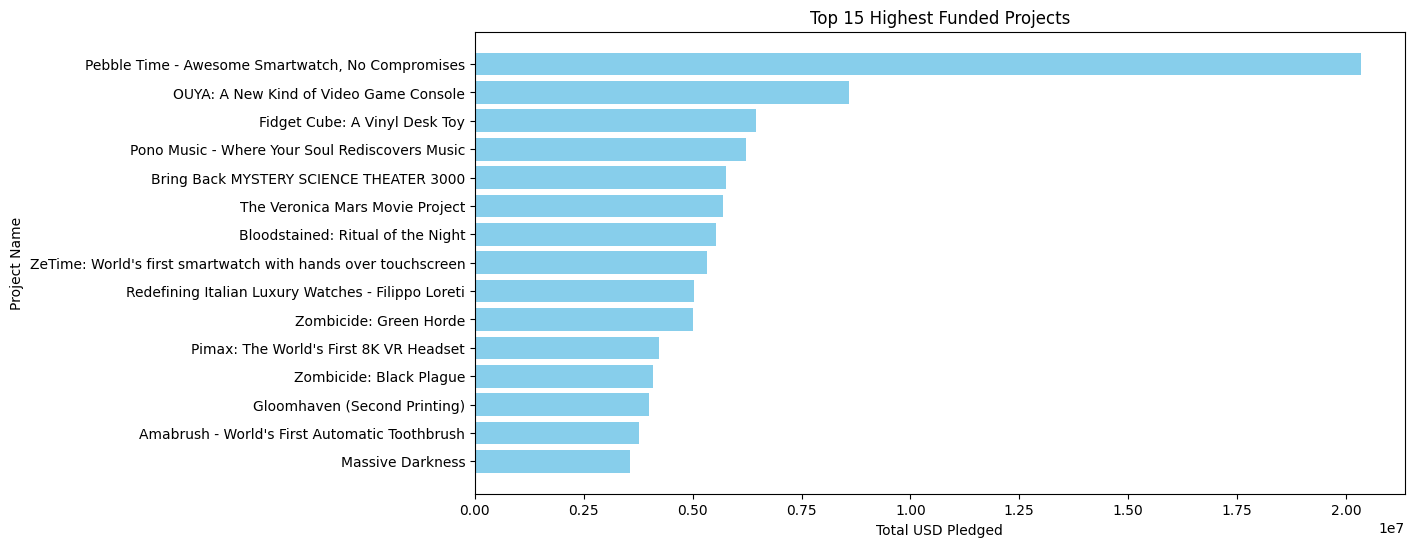

In [305]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
top_15_projects_pd = top_15_projects.toPandas()

# Plotting the top 15 highest funded projects
plt.figure(figsize=(12, 6))
plt.barh(top_15_projects_pd['name'], top_15_projects_pd['total_usd_pledged_real'], color='skyblue')
plt.xlabel('Total USD Pledged')
plt.ylabel('Project Name')
plt.title('Top 15 Highest Funded Projects')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest funded project at the top
plt.show()

## Query Insights

A lot of the projects here fall under the Product Design subcategory.

## Query 4

### Top 15 projects with the highest set funding goals.

In [306]:
# Ordering by goal in descending order and selecting the top 15
top_15_ambitious_projects = data.select("ID", "name", "main_category","state","usd_goal_real") \
    .orderBy("usd_goal_real", ascending=False) \
    .limit(15)

# Show the top 15 most ambitious projects
top_15_ambitious_projects.show(truncate=False)

+----------+------------------------------------------------------------+-------------+---------+--------------+
|ID        |name                                                        |main_category|state    |usd_goal_real |
+----------+------------------------------------------------------------+-------------+---------+--------------+
|1243678698|FUCK Potato Salad. Paleo Potato Brownies!                   |Food         |failed   |1.6636139071E8|
|1371612630|Wax Apple                                                   |Film & Video |failed   |1.0E8         |
|1741515953|Let's prove the earth is FLAT! (Suspended) (Suspended)      |Journalism   |suspended|1.0E8         |
|1168153740|Sage: Warrior Of The Fallen Gods (Movie)                    |Film & Video |failed   |1.0E8         |
|1370542565|Art Is Fabulous                                             |Art          |failed   |1.0E8         |
|1119122774|Help me start a fair media company, Trump Media             |Journalism   |failed   

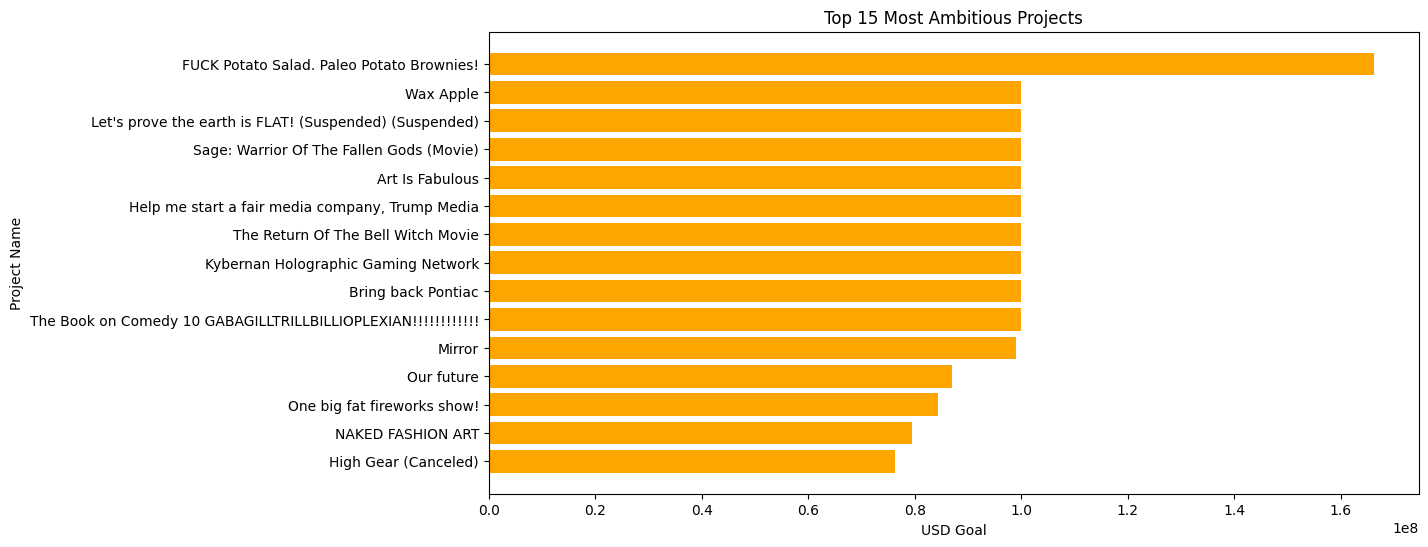

In [307]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
top_15_ambitious_projects_pd = top_15_ambitious_projects.toPandas()

# Plotting the top 15 most ambitious projects
plt.figure(figsize=(12, 6))
plt.barh(top_15_ambitious_projects_pd['name'], top_15_ambitious_projects_pd['usd_goal_real'], color='orange')
plt.xlabel('USD Goal')
plt.ylabel('Project Name')
plt.title('Top 15 Most Ambitious Projects')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest goal project at the top
plt.show()

## Query Insights

Aside from the one projects that was canceled,live and suspended all other projects failed here. Their goals must have been set too high and seen as being too unreasonable for the idea they were selling

## Query 5

Here we divide the projects into two different categories, “complete” projects (projects that have reached their deadline, i.e. successful and failed pojects) and “incomplete” projects (projects that have not reached their deadline, i.e. live, cancelled, or suspended projects).

In [308]:
from pyspark.sql.window import Window
from pyspark.sql.functions import when, col, count, lit

# Filter out projects with state as "undefined"
data = data.filter(col("state") != "undefined")

# Categorize projects into "complete" and "incomplete" based on their status
data = data.withColumn("project_group",
                       when((col("state") == "successful") | (col("state") == "failed"), "complete")
                       .otherwise("incomplete"))

# Group by project group and status, and calculate the count of each status
status_counts = data.groupBy("project_group", "state").agg(count("*").alias("status_count"))

# Calculate the proportion of project statuses for each group
proportion = status_counts.withColumn("status_proportion", col("status_count") / sum("status_count").over(Window.partitionBy("project_group")))

# Convert Spark DataFrame to Pandas DataFrame for visualization
proportion_pd = proportion.toPandas()

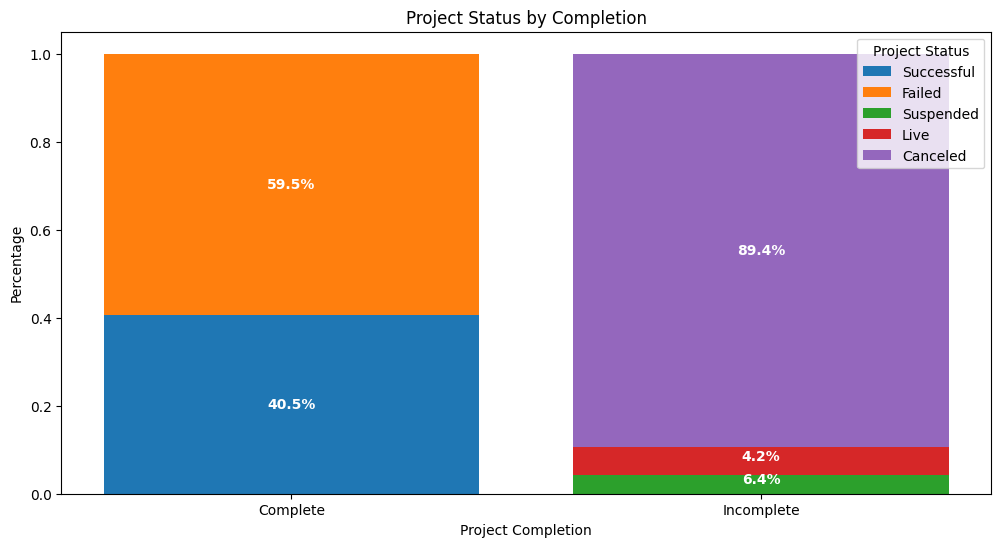

In [309]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))

# Create a stacked bar plot
complete = proportion_pd[proportion_pd['project_group'] == 'complete']
incomplete = proportion_pd[proportion_pd['project_group'] == 'incomplete']

categories = proportion_pd['state'].unique()
categories = [c for c in ["successful", "failed", "suspended", "live", "canceled"] if c in categories]

# Plot complete projects
complete_bottoms = None
incomplete_bottoms = None

for category in categories:
    complete_values = complete[complete['state'] == category]['status_proportion'].values
    incomplete_values = incomplete[incomplete['state'] == category]['status_proportion'].values

    if len(complete_values) > 0:
        plt.bar("Complete", complete_values[0], bottom=complete_bottoms, label=category.capitalize())
        if complete_bottoms is None:
            complete_bottoms = complete_values[0]
        else:
            complete_bottoms += complete_values[0]

    if len(incomplete_values) > 0:
        plt.bar("Incomplete", incomplete_values[0], bottom=incomplete_bottoms, label=category.capitalize())
        if incomplete_bottoms is None:
            incomplete_bottoms = incomplete_values[0]
        else:
            incomplete_bottoms += incomplete_values[0]

# Add labels and title
plt.xlabel('Project Completion')
plt.ylabel('Percentage')
plt.title('Project Status by Completion')
plt.xticks([0, 1], ['Complete', 'Incomplete'])
plt.legend(title='Project Status', loc='best')

# Display percentages on bars
complete_bottoms = 0
incomplete_bottoms = 0

for idx, row in proportion_pd.iterrows():
    if row['project_group'] == 'complete':
        plt.text(0, complete_bottoms + row['status_proportion'] / 2, f"{row['status_proportion']*100:.1f}%",
                 ha='center', va='center', color='white', weight='bold')
        complete_bottoms += row['status_proportion']
    elif row['project_group'] == 'incomplete':
        plt.text(1, incomplete_bottoms + row['status_proportion'] / 2, f"{row['status_proportion']*100:.1f}%",
                 ha='center', va='center', color='white', weight='bold')
        incomplete_bottoms += row['status_proportion']

plt.show()

## Query Insights

Now we know that approximately 60% of completed projects failed and only approximately 40% succeeded. Approximately 90% of incomplete projects were cancelled.

## Query 6

### In this query checks Average Pledged Amount and Goal Amount by State

In [310]:
# 2. Average pledged amount and goal amount by state
result2 = data.groupBy("state").agg(avg("usd_pledged_real").alias("avg_pledged"), avg("goal").alias("avg_goal")) \
             .limit(5)
result2.show()
pd_result2 = result2.toPandas()

+----------+-----------------+------------------+
|     state|      avg_pledged|          avg_goal|
+----------+-----------------+------------------+
| suspended|6899.276498237371|164251.62984723854|
|    failed|1327.093172315676| 65387.08451678413|
|  canceled| 2257.05861915245| 71459.88127627959|
|successful|22689.47450679081| 10253.40760265893|
|      live|6125.857839694652|110157.78473282442|
+----------+-----------------+------------------+



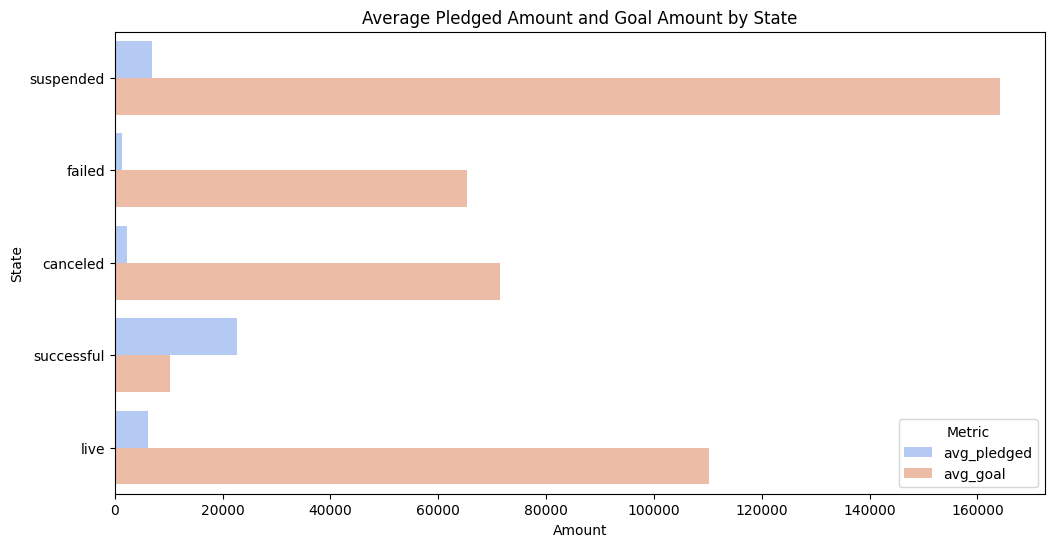

In [311]:
# 2. Bar Plot: Average Pledged Amount and Goal Amount by State
plt.figure(figsize=(12, 6))
pd_result2_melted = pd_result2.melt(id_vars='state', value_vars=['avg_pledged', 'avg_goal'], var_name='Metric', value_name='Amount')
sns.barplot(x='Amount', y='state', hue='Metric', data=pd_result2_melted, palette='coolwarm')
plt.title('Average Pledged Amount and Goal Amount by State')
plt.xlabel('Amount')
plt.ylabel('State')
plt.legend(title='Metric')
plt.show()

## Query Insights

AS you can see the key for successfull project is avg pledged more than the average goal.

## Query 7

### In this query we are checking the average goal in each category

In [312]:
# Group by main_category and calculate the sum of usd_goal_real and count of projects
goal_avg = data.groupBy('main_category').agg(
    sum('usd_goal_real').alias('goal'),
    count('*').alias('projects')
)

# Calculate average goal per category
goal_avg = goal_avg.withColumn('avg', col('goal') / col('projects'))

# Convert to Pandas DataFrame for further processing and plotting
goal_avg_pd = goal_avg.toPandas()

# Sort by average goal in descending order
goal_avg_pd = goal_avg_pd.sort_values(by='avg', ascending=False)

# Convert main_category to categorical type with specified order
goal_avg_pd['main_category'] = pd.Categorical(goal_avg_pd['main_category'], categories=goal_avg_pd['main_category'], ordered=True)

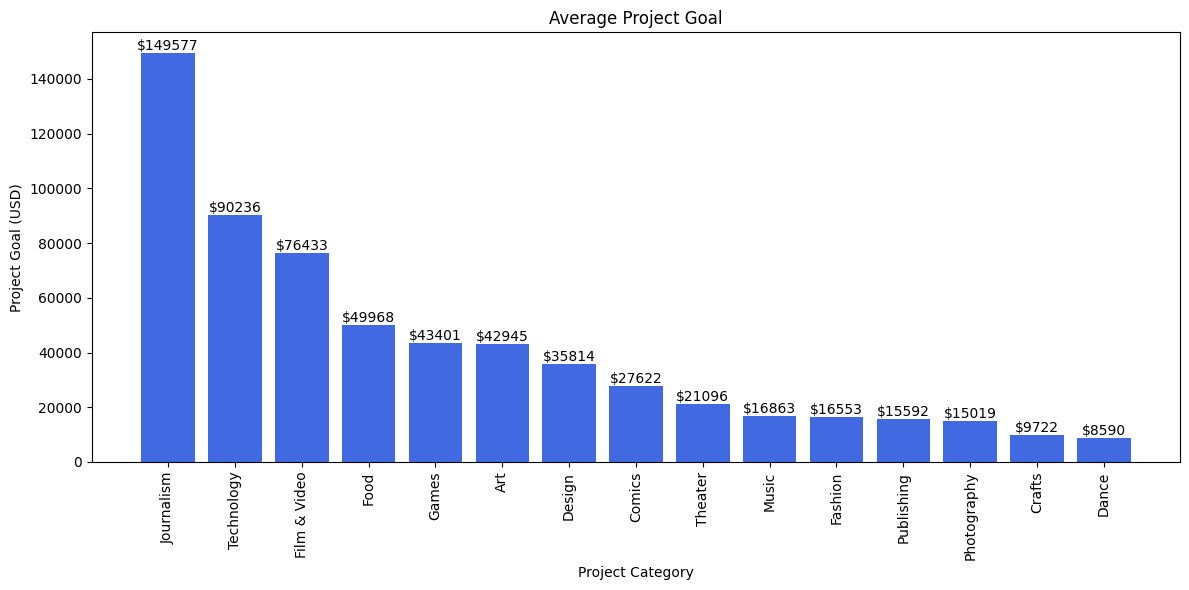

In [313]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 6))
plt.bar(goal_avg_pd['main_category'], goal_avg_pd['avg'], color='royalblue')
plt.xlabel('Project Category')
plt.ylabel('Project Goal (USD)')
plt.title('Average Project Goal')
plt.xticks(rotation=90)
plt.tight_layout()

# Add labels on top of the bars
for index, value in enumerate(goal_avg_pd['avg']):
    plt.text(index, value, f'${value:.0f}', ha='center', va='bottom')

# Show the plot
plt.show()

## Query Insights

Technology, Journalism, and Film & Video have the highest average project goals by far. On the opposite side, we find Dance, Crafts, and Photography.

## Query 8

### In this query we want to know Total Amount Pledged by Main Category

In [314]:
# 4. Total amount pledged by main category
result4 = data.groupBy("main_category").agg(sum("usd_pledged_real").alias("total_pledged")) \
             .orderBy("total_pledged", ascending=False) \
             .limit(5)
result4.show()
pd_result4 = result4.toPandas()

+-------------+--------------------+
|main_category|       total_pledged|
+-------------+--------------------+
|        Games| 3.456949768400006E8|
|       Design| 3.368732355899997E8|
|   Technology| 3.298863121700001E8|
| Film & Video|1.8937652258999985E8|
|        Music| 8.853495351999992E7|
+-------------+--------------------+



<ipython-input-315-97571dbf7686>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_pledged', y='main_category', data=pd_result4, palette='magma')


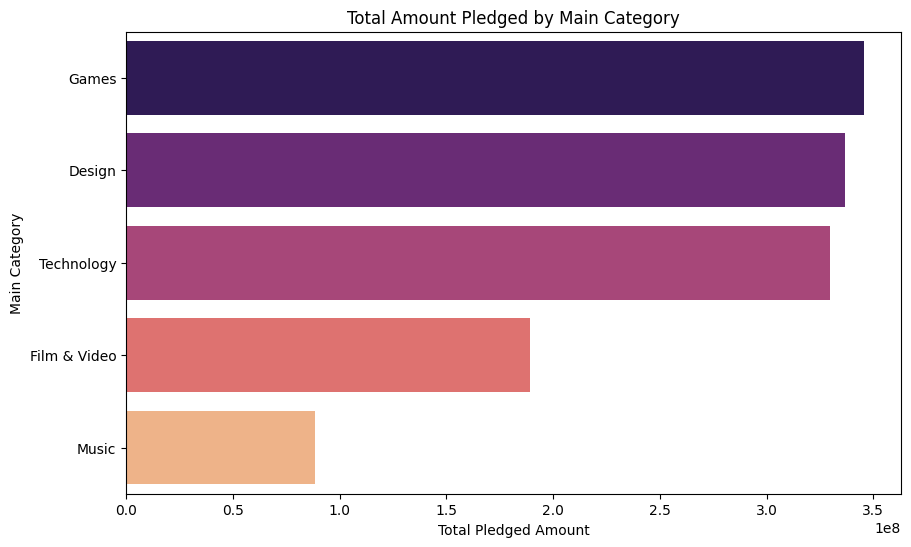

In [315]:
# 4. Bar Plot: Total Amount Pledged by Main Category
plt.figure(figsize=(10, 6))
sns.barplot(x='total_pledged', y='main_category', data=pd_result4, palette='magma')
plt.title('Total Amount Pledged by Main Category')
plt.xlabel('Total Pledged Amount')
plt.ylabel('Main Category')
plt.show()

## Query Insights

As we can see in the that games have the total most pledged amount

## Query 9

### In this query we are checking the country that has the most Backers

In [316]:
# 5. Number of backers by country
result5 = data.groupBy("country").agg(sum("backers").alias("total_backers")) \
             .orderBy("total_backers", ascending=False) \
             .limit(5)
result5.show()
pd_result5 = result5.toPandas()

+-------+-------------+
|country|total_backers|
+-------+-------------+
|     US|     15316385|
|     GB|      1364147|
|     CA|       557773|
|     AU|       287764|
|     DE|       204274|
+-------+-------------+



<ipython-input-317-3030160ebff2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_backers', y='country', data=pd_result5, palette='Greens')


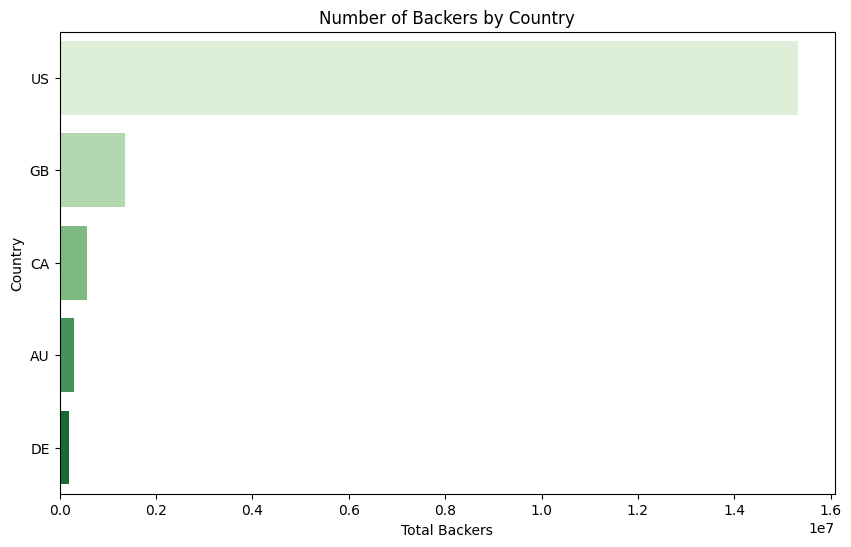

In [317]:
# 5. Bar Plot: Number of Backers by Country
plt.figure(figsize=(10, 6))
sns.barplot(x='total_backers', y='country', data=pd_result5, palette='Greens')
plt.title('Number of Backers by Country')
plt.xlabel('Total Backers')
plt.ylabel('Country')
plt.show()

## Query Insights

Turns Out that USA has the most number of backers

## Query 10

### Total Amount of projects of each category

In [318]:
# 1. Total count of projects by main category
result1 = data.groupBy("main_category").agg(count("*").alias("total_projects")) \
             .orderBy("total_projects", ascending=False) \
             .limit(5)
result1.show()
pd_result1 = result1.toPandas()

+-------------+--------------+
|main_category|total_projects|
+-------------+--------------+
| Film & Video|         29417|
|        Music|         23046|
|   Publishing|         18509|
|        Games|         16539|
|   Technology|         15160|
+-------------+--------------+



<ipython-input-319-f81bfdaa56c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_projects', y='main_category', data=pd_result1, palette='viridis')


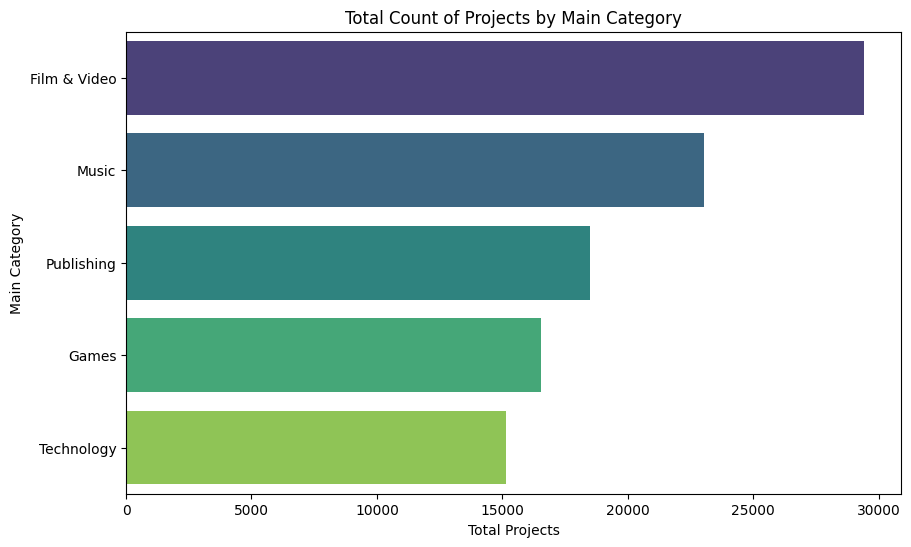

In [319]:
# 1. Bar Plot: Total Count of Projects by Main Category
plt.figure(figsize=(10, 6))
sns.barplot(x='total_projects', y='main_category', data=pd_result1, palette='viridis')
plt.title('Total Count of Projects by Main Category')
plt.xlabel('Total Projects')
plt.ylabel('Main Category')
plt.show()

## Query Insights

The category Film and video has the most total amount of projects

# ML MODELS

## Preparing Data for Machine Learning

In [320]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler

data = data.filter(col("state") != "live")
data = data.withColumn("label", when(col("state") == "successful", 1).otherwise(0))

feature_columns = ["goal","backers", "usd_goal_real"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

data = data.select("features", "label")

In [321]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

## Training models and calculating accuracy

## LogisticRegression

In [322]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

## DecisionTreeClassifier

In [323]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

## RandomForestClassifier

In [324]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

## Evaluation

In [325]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label")

lr_accuracy = evaluator.evaluate(lr_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")


Logistic Regression Accuracy: 0.9598698978609949
Decision Tree Accuracy: 0.9212398194312914
Random Forest Accuracy: 0.9698680212641454


## Confusion Matrix

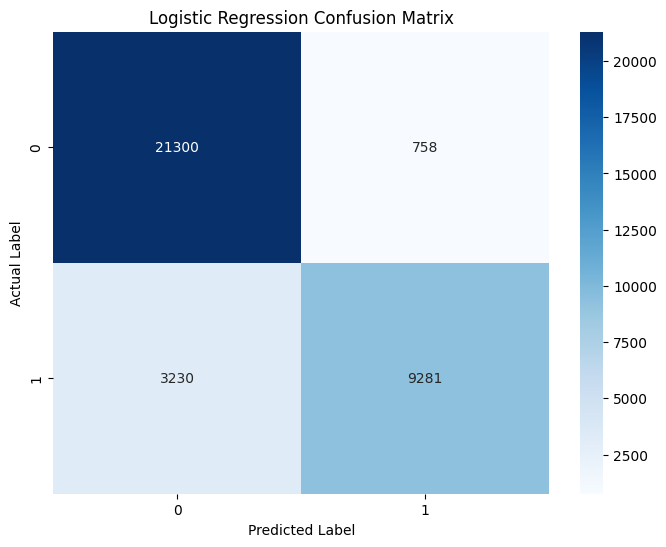

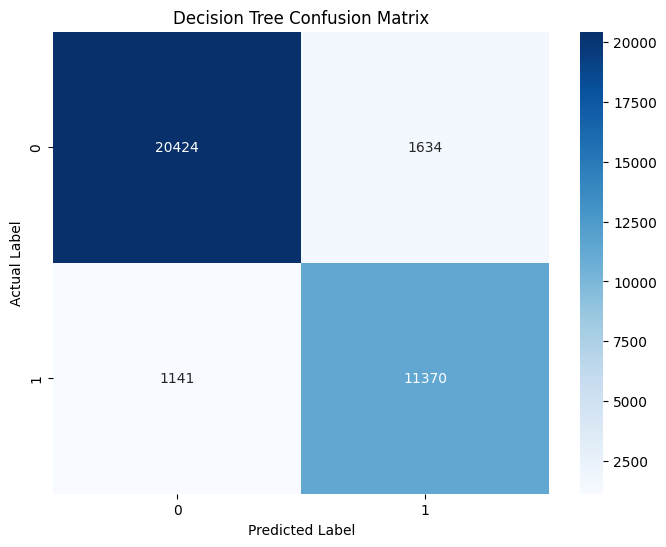

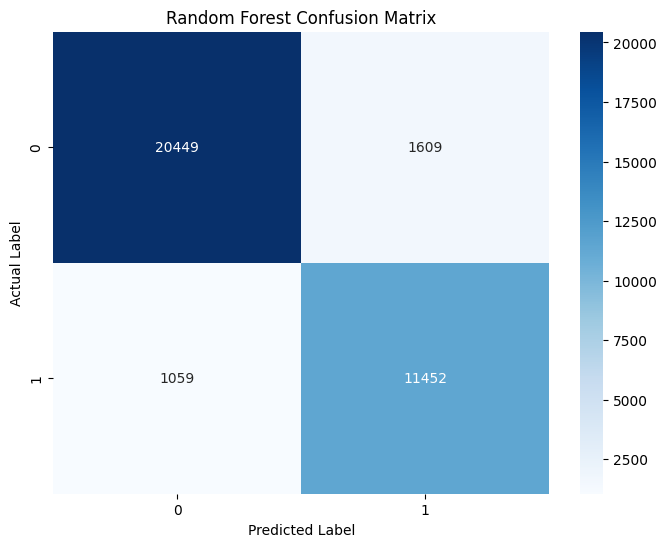

In [326]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F  # Import functions as F


# Confusion Matrix
def get_confusion_matrix(predictions):
    # Convert prediction and label columns to integer type for crosstab
    predictions = predictions.withColumn("prediction", F.col("prediction").cast("integer"))
    predictions = predictions.withColumn("label", F.col("label").cast("integer"))
    # Create confusion matrix using crosstab
    cm = predictions.crosstab("label", "prediction")
    cm = cm.toPandas()
    cm.set_index(cm.columns[0], inplace=True)
    return cm

# Generate confusion matrices for all models
lr_cm = get_confusion_matrix(lr_predictions)
dt_cm = get_confusion_matrix(dt_predictions)
rf_cm = get_confusion_matrix(rf_predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(lr_cm, "Logistic Regression")
plot_confusion_matrix(dt_cm, "Decision Tree")
plot_confusion_matrix(rf_cm, "Random Forest")